<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v7: Productionising Gradient capturing and visualisation
This notebook carries on from v4 with work to productionise the capture and display of gradient information.

However it takes a more cautious small-step approach:
* Uses a custom-training loop instead of trying to wrap an optimizer (later experience has shown that the optimizer wrapping needs some more work to be compatible with the later versions of Keras)
* Doesn't try to work out gradient sign changes, just the raw gradients.
* Supports some more variations of model architecture.
* Tries to be as close to plug'n'play as possible.

In [129]:
# Clone repo and load its modules

import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
!cd repo && git checkout c4f0bfe
#!cd repo && git pull

import sys
sys.path.append('repo')

import toolkit
from importlib import reload
reload(toolkit)

HEAD is now at c4f0bfe Minor refinement and naming tidy up
Note: switching to 'c4f0bfe'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at c4f0bfe Minor refinement and naming tidy up


<module 'toolkit' from '/content/repo/toolkit.py'>

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit

In [3]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

## Baseline

In [110]:
def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


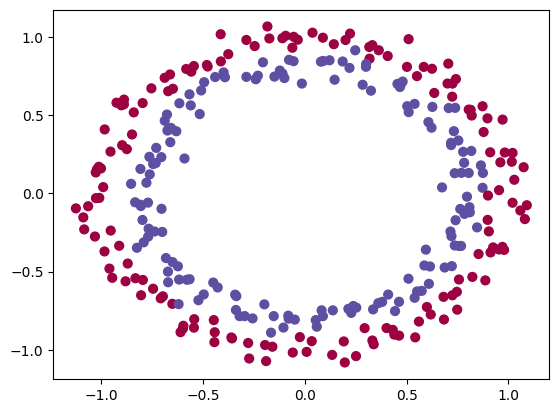

In [106]:
def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

Epoch    50 - 86.52ms/epoch: loss: 0.6558  
Epoch   100 - 42.18ms/epoch: loss: 0.2255  
Epoch   150 - 28.63ms/epoch: loss: 0.0388  
Epoch   200 - 28.30ms/epoch: loss: 0.0148  
Epoch   250 - 29.56ms/epoch: loss: 0.0075  
Epoch   300 - 26.70ms/epoch: loss: 0.0043  
Epoch   350 - 26.54ms/epoch: loss: 0.0027  
Epoch   400 - 27.72ms/epoch: loss: 0.0017  
Epoch   450 - 37.96ms/epoch: loss: 0.0012  
Epoch   500 - 44.62ms/epoch: loss: 0.0008  
Total training time: 18.93 secs


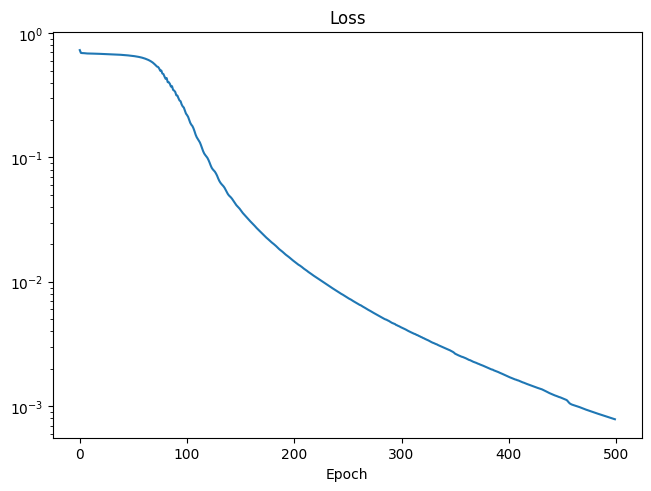

In [76]:
tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=500, batch_size=train_X.shape[0], verbose=0, callbacks=[toolkit.LessVerboseProgressLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

In [18]:
model.loss

'binary_crossentropy'

In [19]:
model.metrics

[<Mean name=loss>]

## Custom training loop
First, we'll just check that we can run a custom training loop without any extra processing and confirm that it runs at about the same pace.

Surprisingly, it turns out that my custom training loop runs in about 25% of the time per epoch. The reference implementation contains lots of extra logic, so this must just be python at work when the overheads are multiplied by so many tiny epochs.

Execution mode: autograph
Epoch    50 - 40.69ms/epoch: loss: 0.5842  mse: 0.1970  
Epoch   100 - 8.07ms/epoch: loss: 0.1716  mse: 0.0362  
Epoch   150 - 7.47ms/epoch: loss: 0.0482  mse: 0.0074  
Epoch   200 - 7.74ms/epoch: loss: 0.0221  mse: 0.0027  
Epoch   250 - 7.51ms/epoch: loss: 0.0119  mse: 0.0012  
Epoch   300 - 7.45ms/epoch: loss: 0.0071  mse: 0.0006  
Epoch   350 - 6.95ms/epoch: loss: 0.0046  mse: 0.0003  
Epoch   400 - 7.58ms/epoch: loss: 0.0032  mse: 0.0002  
Epoch   450 - 7.37ms/epoch: loss: 0.0017  mse: 0.0001  
Epoch   500 - 7.36ms/epoch: loss: 0.0010  mse: 0.0000  
Total training time: 5.43 secs


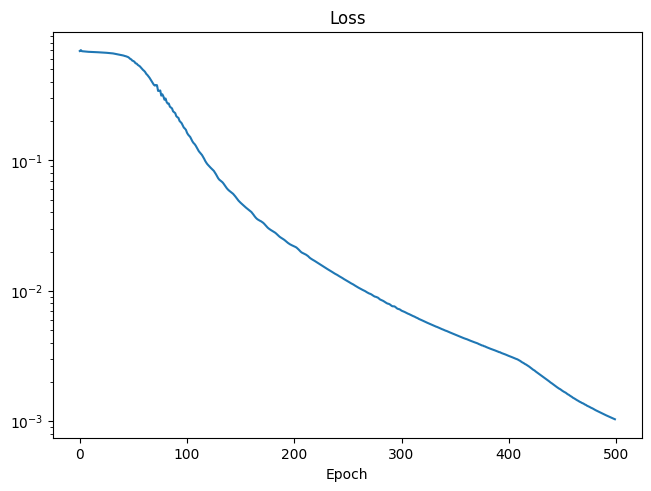

In [73]:
tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(train_X.shape[0])
history = toolkit.fit(model, dataset, epochs=500, verbose=0, callbacks=[toolkit.LessVerboseProgressLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

## Capturing gradients
Now we build out the functionality to capture the gradients

Epoch   100 - 65.88ms/epoch: loss: 0.1965  mse: 0.0427  
Epoch   200 - 14.99ms/epoch: loss: 0.0121  mse: 0.0012  
Epoch   300 - 15.91ms/epoch: loss: 0.0033  mse: 0.0002  
Epoch   400 - 15.30ms/epoch: loss: 0.0013  mse: 0.0000  
Epoch   500 - 16.67ms/epoch: loss: 0.0006  mse: 0.0000  
Epoch   600 - 27.56ms/epoch: loss: 0.0003  mse: 0.0000  
Epoch   700 - 37.97ms/epoch: loss: 0.0002  mse: 0.0000  
Epoch   800 - 14.51ms/epoch: loss: 0.0001  mse: 0.0000  
Epoch   900 - 15.41ms/epoch: loss: 0.0001  mse: 0.0000  
Epoch  1000 - 32.01ms/epoch: loss: 0.0001  mse: 0.0000  
Total training time: 25.79 secs


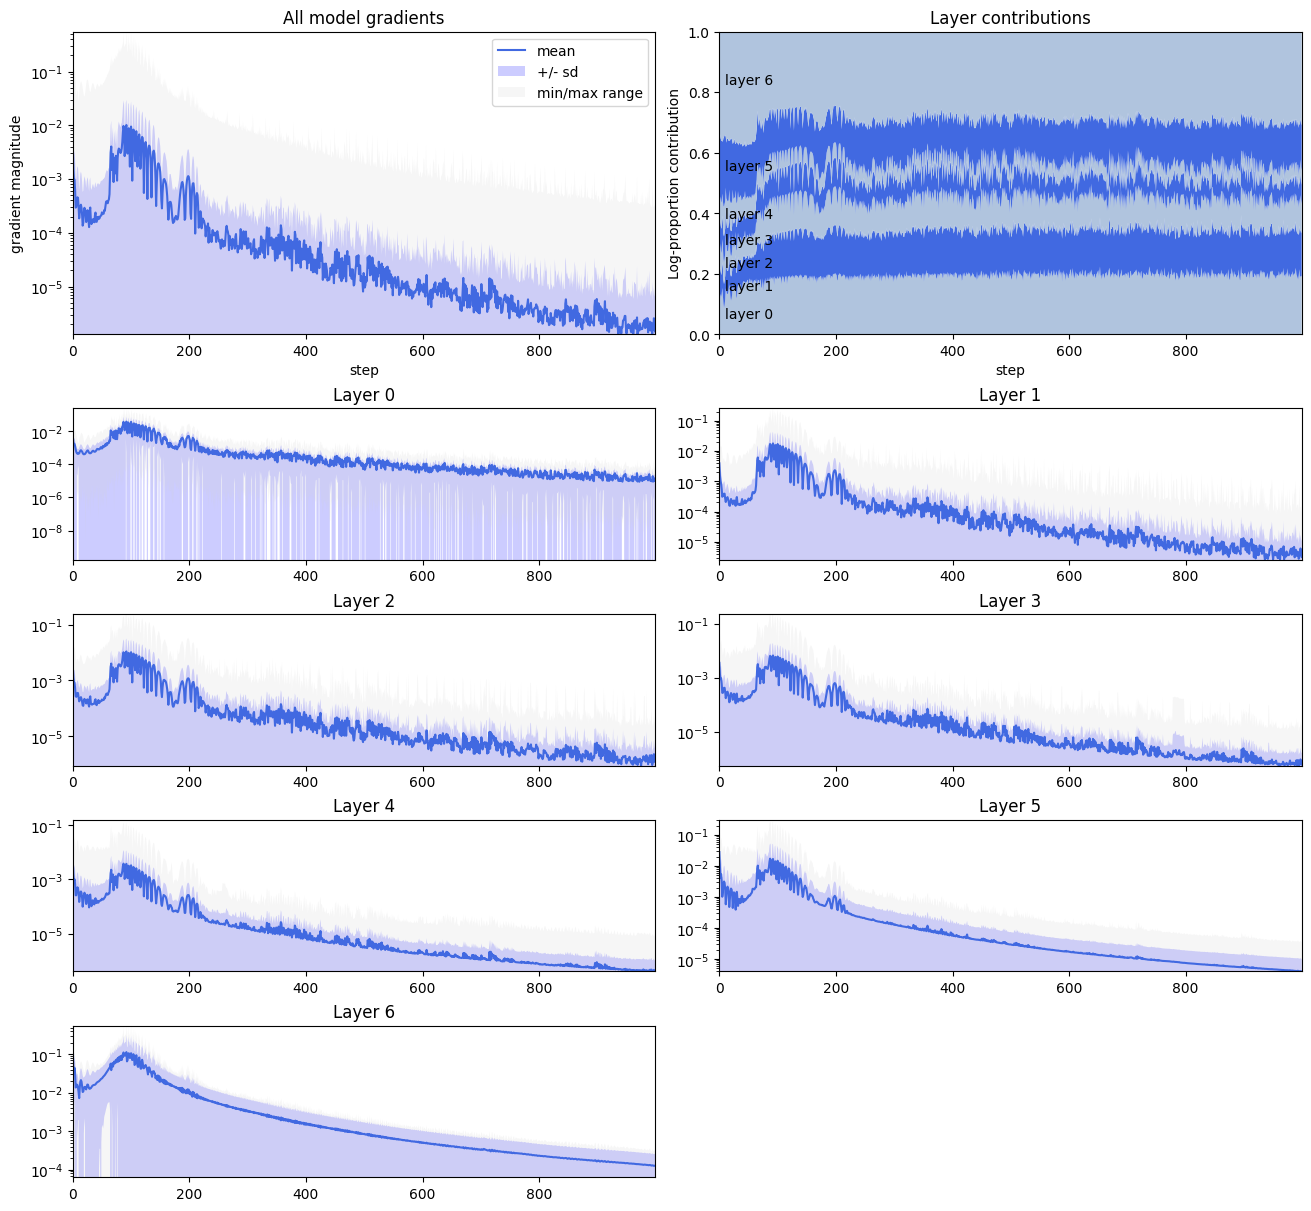

In [111]:
reload(toolkit)
tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(train_X.shape[0])
gradients = toolkit.GradientHistoryCallback()
history = toolkit.fit(model, dataset, epochs=1000, verbose=0, callbacks=[toolkit.LessVerboseProgressLogger()], gradient_callback=gradients)
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

#list_gradients(gradients.gradients_list)
#list_stats(gradients)

toolkit.show_gradient_stats(gradients)


In [112]:
def list_stats(gradients_cb):
  print(f"Gradients callback summary:")
  if hasattr(gradients_cb,'epochs'):
    print(f"  Epochs: {len(gradients_cb.epochs)} ({gradients_cb.epochs[0]} .. {gradients_cb.epochs[-1]})")
  if hasattr(gradients_cb,'steps'):
    print(f"steps: {len(gradients_cb.steps)} ({gradients_cb.steps[0]} .. {gradients_cb.steps[-1]})")
  print(f"Model:")
  for key in gradients_cb.model_stats.keys():
    stats = gradients_cb.model_stats[key]
    print(f"  {key:4} ({len(stats)}): {stats[0:3]} .. {stats[-3:]}")
  for l in range(len(gradients_cb.layer_stats)):
    if gradients_cb.layer_stats[l] is not None:
      print(f"Layer {l}:")
      for key in gradients_cb.layer_stats[l].keys():
        stats = gradients_cb.layer_stats[l][key]
        print(f"  {key:4} ({len(stats)}): {stats[0:3]} .. {stats[-3:]}")

list_stats(gradients)

Gradients callback summary:
steps: 1000 (0 .. 999)
Model:
  mean (1000): [0.00420848 0.00151495 0.00094895] .. [2.5685604e-06 1.7976503e-06 1.4675893e-06]
  min  (1000): [0. 0. 0.] .. [0. 0. 0.]
  max  (1000): [0.36669725 0.12769204 0.08044162] .. [0.00029765 0.00031297 0.00033359]
  std  (1000): [0.00997074 0.00368513 0.00190616] .. [7.0917990e-06 5.1483435e-06 4.8987745e-06]
Layer 0:
  mean (1000): [0.00532425 0.00209636 0.00185033] .. [1.4917053e-05 1.0644071e-05 1.0395755e-05]
  min  (1000): [1.2014934e-05 7.7402219e-06 1.9082363e-06] .. [7.8944140e-09 3.2203388e-08 1.9543222e-08]
  max  (1000): [0.03052923 0.01171419 0.00989831] .. [8.391851e-05 5.599030e-05 7.827851e-05]
  std  (1000): [0.00513081 0.00207094 0.00181492] .. [1.4173443e-05 1.0686635e-05 1.2737198e-05]
Layer 1:
  mean (1000): [0.00390963 0.00151967 0.00101966] .. [6.0589196e-06 4.2759284e-06 3.1557558e-06]
  min  (1000): [0. 0. 0.] .. [0. 0. 0.]
  max  (1000): [0.05614848 0.02662256 0.0135691 ] .. [1.4627332e-04 9.3

In [70]:
def nearest_even(v: float):
  return round(v / 2) * 2

for v in [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]:
  print(f"{v} -> {nearest_even(v)}")

0 -> 0
0.5 -> 0
1.0 -> 0
1.5 -> 2
2.0 -> 2
2.5 -> 2
3.0 -> 4
3.5 -> 4


In [68]:
src = np.array([1e-3, 1e-1, 1e-2, 1e2])
log_scaled = np.log(src)
log_scaled = log_scaled - (np.min(log_scaled) - 1)  # move everything into positive, with lowest value having a relative unit scale of 1.0
log_scaled /= np.sum(log_scaled)

inverse_scaled = 1/src
inverse_scaled /= np.sum(inverse_scaled)

log_norm_softmax = np.log(src + 1)  # avoid log(0)
log_norm_softmax /= np.sum(log_norm_softmax)

print(f"src:              {src}")
print(f"log-scaled:       {lognorm(src)}")
print(f"log-scaled (ax0): {lognorm(src, axis=0)}")
print(f"------------")
print(f"log-scaled:       {log_scaled}")
print(f"softmax:          {tf.nn.softmax(src)}")
print(f"log:              {np.log(src)}")
print(f"inverse-scaled:   {inverse_scaled}")
print(f"log_norm_softmax: {log_norm_softmax}")

src:              [1.e-03 1.e-01 1.e-02 1.e+02]
log-scaled:       [0.04460168 0.25       0.14730084 0.55809748]
log-scaled (ax0): [0.04460168 0.25       0.14730084 0.55809748]
------------
log-scaled:       [0.04460168 0.25       0.14730084 0.55809748]
softmax:          [3.72379791e-44 4.11131978e-44 3.75746336e-44 1.00000000e+00]
log:              [-6.90775528 -2.30258509 -4.60517019  4.60517019]
inverse-scaled:   [9.00892785e-01 9.00892785e-03 9.00892785e-02 9.00892785e-06]
log_norm_softmax: [2.11696627e-04 2.01869303e-02 2.10750453e-03 9.77493869e-01]


In [60]:
a = np.array([[1, 2, 3], [4, 5, 6]])
a / np.sum(a, axis=1, keepdims=True)

array([[0.16666667, 0.33333333, 0.5       ],
       [0.26666667, 0.33333333, 0.4       ]])

## Complex model
Now with a more complex model that incorporates layers without trainable variables and multiple inputs and outputs.

Epoch    10 - 526.84ms/epoch: dense_329_loss: 0.6830  dense_329_mse: 0.2451  dense_330_loss: 0.6908  dense_330_mse: 0.2489  loss: 1.3738  
Epoch    20 - 18.46ms/epoch: dense_329_loss: 0.6766  dense_329_mse: 0.2418  dense_330_loss: 0.6891  dense_330_mse: 0.2480  loss: 1.3657  
Epoch    30 - 19.04ms/epoch: dense_329_loss: 0.6669  dense_329_mse: 0.2371  dense_330_loss: 0.6871  dense_330_mse: 0.2470  loss: 1.3540  
Epoch    40 - 19.37ms/epoch: dense_329_loss: 0.6474  dense_329_mse: 0.2275  dense_330_loss: 0.6853  dense_330_mse: 0.2462  loss: 1.3327  
Epoch    50 - 17.99ms/epoch: dense_329_loss: 0.6007  dense_329_mse: 0.2055  dense_330_loss: 0.6817  dense_330_mse: 0.2444  loss: 1.2824  
Epoch    60 - 18.51ms/epoch: dense_329_loss: 0.5232  dense_329_mse: 0.1670  dense_330_loss: 0.6725  dense_330_mse: 0.2401  loss: 1.1957  
Epoch    70 - 18.74ms/epoch: dense_329_loss: 0.4472  dense_329_mse: 0.1331  dense_330_loss: 0.6546  dense_330_mse: 0.2320  loss: 1.1018  
Epoch    80 - 19.05ms/epoch: dens

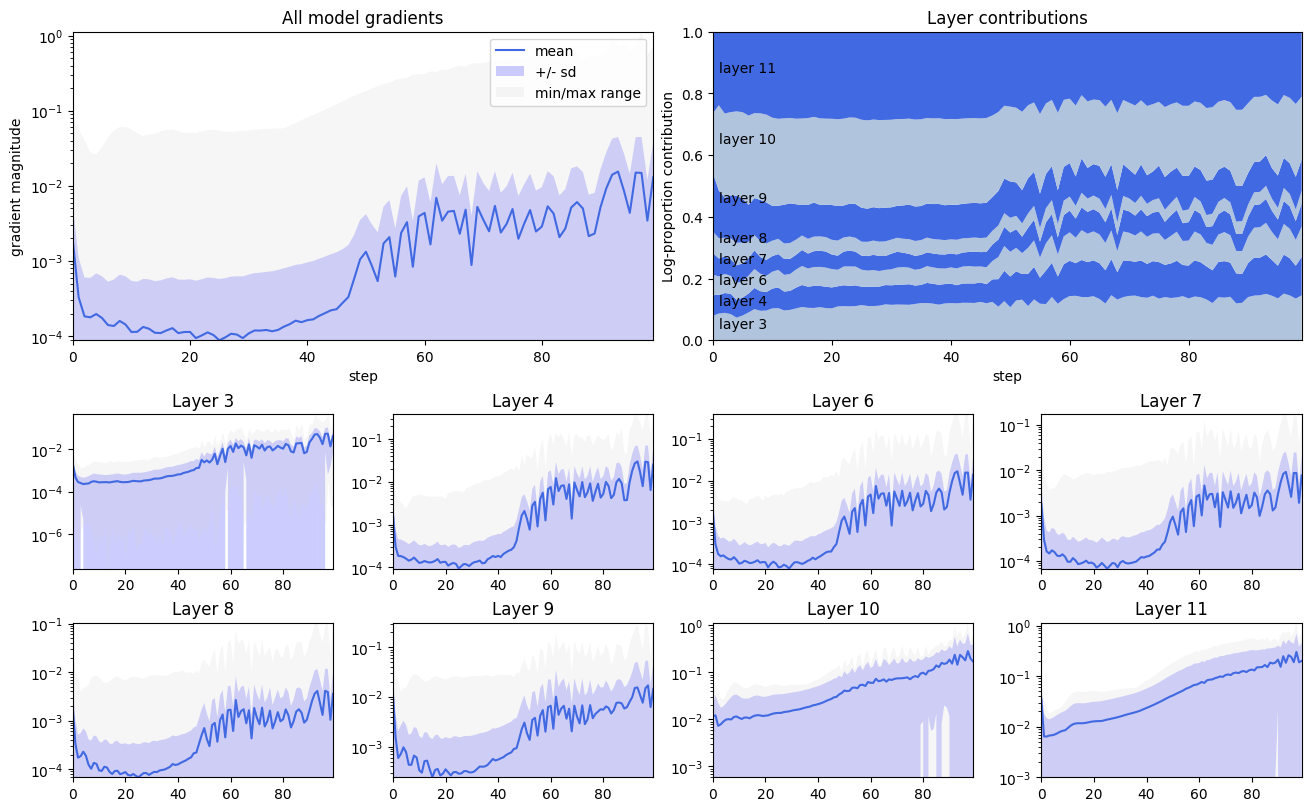

In [128]:
def complex_classification_model():
  kernel_initializer='he_normal'

  input1 = tf.keras.layers.Input(shape=(2,))
  input2 = tf.keras.layers.Input(shape=(2,))
  hidden = tf.keras.layers.Concatenate(axis=-1)([input1, input2])

  hidden = tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer)(hidden)
  hidden = tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer)(hidden)
  hidden = tf.keras.layers.Dropout(0.1)(hidden)
  hidden = tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer)(hidden)
  hidden = tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer)(hidden)
  hidden = tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer)(hidden)
  hidden = tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer)(hidden)

  output1 = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)(hidden)
  output2 = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)(hidden)

  return tf.keras.Model(inputs=[input1, input2], outputs=[output1, output2])

def complex_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  return (train_X, train_X), (train_Y, train_Y)


reload(toolkit)
tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = complex_classification_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse', 'mse'])
train_X, train_Y = complex_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(train_X[0].shape[0])
gradients = toolkit.GradientHistoryCallback()
history = toolkit.fit(model, dataset, epochs=100, verbose=0, callbacks=[toolkit.LessVerboseProgressLogger()], gradient_callback=gradients)
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

#list_gradients(gradients.gradients_list)
#list_stats(gradients)

toolkit.show_gradient_stats(gradients)

## Appendix: Prove out maths behind implementation of Welford's algorithm

In [118]:
def _compute_stats_numpy(gradients):
  mags = [tf.abs(g).numpy() for g in gradients]
  mags = np.stack(mags)
  print(f"numpy, mags: {mags.shape}")
  return {
      'mean': np.mean(mags),
      'min': np.min(mags),
      'max': np.max(mags),
      'std': np.std(mags)
  }

def _compute_stats_brute(gradients):
  mags = [tf.abs(g) for g in gradients]
  mags = tf.stack(mags)
  return {
      'mean': tf.reduce_mean(mags).numpy(),
      'min': tf.reduce_min(mags).numpy(),
      'max': tf.reduce_max(mags).numpy(),
      'std': tf.math.reduce_std(mags).numpy()
  }

def _compute_stats(gradients):
  n = tf.constant(0.0, dtype=tf.float32)
  mean = tf.constant(0.0, dtype=tf.float32)
  M2 = tf.constant(0.0, dtype=tf.float32)  # Sum of squared differencse from the mean
  min = None
  max = None

  # TODO: sanity check this against brute-force approach
  for g in gradients:
    g_mags = tf.abs(g)
    g_size = tf.size(g, out_type=tf.float32)
    g_min = tf.reduce_min(g_mags)
    g_max = tf.reduce_max(g_mags)
    g_sum = tf.reduce_sum(g_mags)
    g_mean = g_sum / g_size
    g_var = tf.reduce_sum((g_mags - g_mean)**2)

    if min == None or g_min < min:
      min = g_min
    if max == None or g_max > max:
      max = g_max

    # Welford's algorithm for computing running statistics
    delta = g_mean - mean
    n += g_size
    mean += delta * (g_size / n)
    M2 += g_var + delta**2 * (g_size * (n - g_size) / n)

  if n > 1:
    return {
        'mean': mean.numpy(),
        'min': min.numpy(),
        'max': max.numpy(),
        'std': tf.sqrt(M2 / n).numpy()
    }
  else:
    return {
        'mean': 0.0,
        'min': 0.0,
        'max': 0.0,
        'std': 0.0
    }


gradients = [
    tf.constant([0.1, 0.2, 0.3]),
    tf.constant([0.4, 0.5, 0.6]),
    tf.constant([0.7, 0.8, 0.9]),
]

print(f"numpy:     {_compute_stats_numpy(gradients)}")
print(f"brute:     {_compute_stats_brute(gradients)}")
print(f"efficient: {_compute_stats(gradients)}")

numpy, mags: (3, 3)
numpy:     {'mean': 0.5, 'min': 0.1, 'max': 0.9, 'std': 0.2581989}
brute:     {'mean': 0.5, 'min': 0.1, 'max': 0.9, 'std': 0.2581989}
efficient: {'mean': 0.5, 'min': 0.1, 'max': 0.9, 'std': 0.2581989}
